# Adaboost
Part 2 of the course project in *Artificial intelligence applied to engineering* at ETSEIB, UPC, spring 2024. The team members contributing to the deliverable is 
- Lise Jakobsen
- Julie Sørlie Lund
- Magnus Ingnes Sagmo

The dataset used in this deliverable can be retrieved from [Kaggle](https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset).

## Data set review

#### Target class
The target class, `HeartDisease`, is a boolean class telling whether the patient has a heart disease. Subsequently, this is a classification problem.

#### Features
The data set has 11 features. Two of these, `ChestPainType` and `RestingECG`, are one-hot encoded. 

#### Preprocessing method
Before using AdaBoost
- zero values of `Cholesterol` are imputed using `sklearn.impute.KNNImputer`.
- the data is split into train and test set using `sklearn.model_selection.train_test_split`.
- the data is normalized using `sklearn.preprocessing.StandardScaler`.

In addition, we will try to both keep and remove outliers to see what produces best predictions. 

## Performance metrics

#### Recall
In the case of detecting heart diseases it is crucial to minimize the number of false negatives (people with a heart disease going unnoticed). We will therefore focus on minimizing recall.

#### F1-score
By solely focusing on recall, we can end with a too high number of false positives (by choosing a model that classifies everything as heart disease). We will therefore also look at the F1-score, as it offers a balance between precision and recall. 

#### Precision-recall curve
The precision-recall curve is a good way to visualize how well the model balances precision and recall. 

#### Confusion matrix
A good way to look at the number of false positives is looking at the confusion matrix. This will allow us to simultaneously look at false negatives, true positives and true negatives. 

## Hyperparameters

#### Number of estimators
The `n_estimators` decides the maximum number of estimators at which boosting is terminated.

#### Learning rate
The `learning_rate` is the weight applied to each classifier at each boosting iteration.

### Load data

We will split the data in training and test set, and only use the train data for the cross validation in the grid search. This will reduce the amount of data used to train the models and tuning hyperparameters, butt will ensure no data leakage and help reduce overfitting of the model. 

In [10]:
%load_ext autoreload
%autoreload 2

from preprocessor import Preprocessor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, f1_score, precision_recall_curve, auc, precision_score
import numpy as np
import pandas as pd
from sklearn.model_selection import validation_curve

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
prep = Preprocessor()

X_train, X_test, y_train, y_test = prep.get_data(test_size=0.25, impute_method='knn', remove_outliers=True, scaling_method='standard')

### Set up hyperparameters grid

We will explore
- `n_estimators`: range: 50 to 500
- `learning rate`: range: 0.01 to 1.0

In [12]:
# Define the parameter grid
param_grid = {
    'n_estimators': np.arange(50, 501, 50),
    'learning_rate': [0.01, 0.1, 0.3, 0.5, 1.0]
}


### Perform grid search

As stated above, we will focus mainly on recall and F1-score for our model evaluation. For the grid search we will use F1-score as evaluation metric, because
- using recall can cause an unacceptably poor precision.
- F1-score also considers true positives.

To narrow the number of combinations we will further evaluate, we retrieve the six best combinations from the grid search.

In [13]:
# Define model
adaBoost = AdaBoostClassifier(random_state=2, algorithm='SAMME')

# Perform grid search
grid_search = GridSearchCV(adaBoost, param_grid, cv=5, scoring='f1', return_train_score=True)
grid_search.fit(X_train, y_train)

# Extract the six best iterations, based on mean F1 score
results = pd.DataFrame(grid_search.cv_results_)
top_10 = results.nlargest(10, 'mean_test_score')  
# Extract only the interesting columns from the DataFrame
top_10 = top_10[['param_n_estimators', 'param_learning_rate', 'mean_test_score', 'std_test_score']]

top_10

,param_n_estimators,param_learning_rate,mean_test_score,std_test_score
20,50,0.3,0.876094,0.031330
21,100,0.3,0.876070,0.035858
24,250,0.3,0.875373,0.031315
12,150,0.1,0.874978,0.037741
25,300,0.3,0.874964,0.031357
15,300,0.1,0.874915,0.037867
23,200,0.3,0.874453,0.029277
26,350,0.3,0.874061,0.029641
27,400,0.3,0.874061,0.029641
17,400,0.1,0.873434,0.034133


The six best combinations using F1-score are
- in the range 50-400 for `n_estimators`.
- in the range 0.1-0.3 for `learning_rate`.

The combination of hyperparameters with the highest mean test score from the grid search uses n_estimators=50 and learning_rate=0.3. This combination achieves the best balance of high performance and stability, making it the optimal choice for further evaluation. The model is less computationally expensive compared to those with very high n_estimators, without compromising on the results

### Evaluating top 10 combinations
We will continue by examining how these ten top results perform on unseen data. We will look at 
- F1-score
- Recall
- Precision
- Precision-Recall Area Under Curve

In [14]:
# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    # Make prediction
    y_pred = model.predict(X_test)

    # Retrieve scores
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
    pr_auc = auc(recall_curve, precision_curve)

    return recall, f1, precision, pr_auc

In [15]:
# DataFrame with evaluation metric for each of the top 10 models
evaluation_results = pd.DataFrame(columns=['n_estimators', 'learning_rate', 'Recall', 'F1-score', 'Precision', 'Precision-recall AUC'])

# Iterate the top 6 parameter combinations
for (index, row) in top_10.iterrows():

    # Dict with params from the row
    params = {
        'n_estimators': row['param_n_estimators'],
        'learning_rate': row['param_learning_rate'],
    }

    # Fit the model with params
    model = AdaBoostClassifier(n_estimators=params['n_estimators'] , learning_rate=params['learning_rate'], random_state=1,  algorithm='SAMME')
    model.fit(X_train, y_train)
    
    # Evaluate the model
    recall, f1, precision, pr_auc = evaluate_model(model, X_test, y_test)

    new_row = {
        'n_estimators': params['n_estimators'],
        'learning_rate': params['learning_rate'],
        'Recall': round(recall, 3), 
        'Precision': round(precision, 3), 
        'F1-score': round(f1, 3), 
        'Precision-recall AUC': round(pr_auc, 3)
    }
    evaluation_results.loc[len(evaluation_results)] = new_row

evaluation_results = evaluation_results.sort_values(by=['Recall', 'F1-score'])
evaluation_results

,n_estimators,learning_rate,Recall,F1-score,Precision,Precision-recall AUC
4,300,0.3,0.835,0.867,0.902,0.932
1,100,0.3,0.835,0.871,0.910,0.937
5,300,0.1,0.835,0.871,0.910,0.938
6,200,0.3,0.835,0.871,0.910,0.934
9,400,0.1,0.835,0.871,0.910,0.937
2,250,0.3,0.835,0.874,0.917,0.934
0,50,0.3,0.842,0.872,0.903,0.939
8,400,0.3,0.842,0.875,0.911,0.931
7,350,0.3,0.842,0.878,0.918,0.932
3,150,0.1,0.850,0.879,0.911,0.940


The combination of hyperparameters with the highest Recall and highest F1-score from the grid search uses `n_estimators=150` and `learning_rate=0.1`. This combination achieves the highest balance of recall and precision, leading to the best F1-score and solid precision-recall AUC. By selecting this combination, the model ensures robust performance without excessive computational cost or risk of overfitting compared to higher n_estimators values.

### Bias and variance

Next, we examine the model performance in the context of bias and variance by plotting a validation curve for n_estimators and learning_rate.

In [24]:
def plot_validation_curve(param_name, param_range):

    best_params = {'n_estimators':150, 'learning_rate':0.3}

    del best_params[param_name]
    
    # Calculate scores for validation curve
    train_scores, test_scores = validation_curve(
        AdaBoostClassifier(random_state=3,  **best_params, algorithm='SAMME'),
        X_train, y_train, param_name=param_name, 
        param_range=param_range,
        cv=5, scoring="recall", n_jobs=-1)

    # Calculate mean and standard deviation for train and test scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the validation curve
    plt.figure(figsize=(6, 3))
    plt.plot(param_range, train_mean, label="Training score", color="r")
    plt.plot(param_range, test_mean, label="Cross-validation score", color="g")

    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="g", alpha=0.1)

    plt.title("Validation Curve for AdaBoost, recall")
    plt.xlabel(f"{param_name}")
    plt.ylabel("Recall")
    plt.legend(loc="best")
    plt.show()

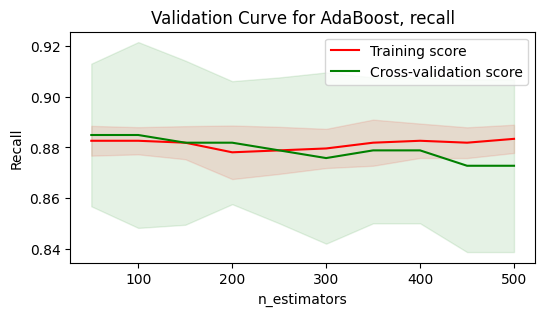

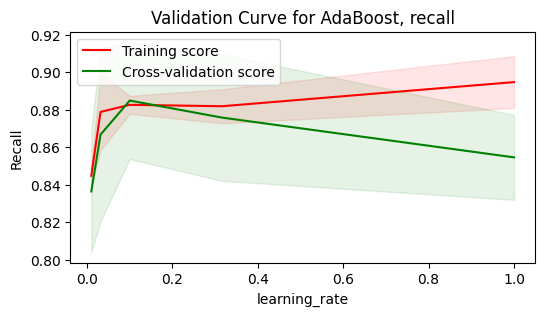

In [25]:
estimator_range = np.arange(50, 501, 50)
plot_validation_curve('n_estimators', estimator_range)

learning_range = np.logspace(-2, 0, 5) 
plot_validation_curve('learning_rate', learning_range)

#### n_estimators
Both the training and cross validation curves are very stable (cross-validation score actually showing a slight decrease), highlighting the robust performance of the AdaBoost algorithm. The choice of `n_estimators=150` appears to be reasonable, as it is not overfitting or udnerfitting to the data, it has a high recall, and it is less computationally expensive than using more estimators. 

#### learning_rate
Our choice of `learning_rate=0.1` appears to be the the best choice for this dataset.

#### Overall conclusion
For n_estimators, a low number of around 150 balances bias and variance, mitigating overfitting. Regarding learning_rate, our choice 0.1 optimizes both training and cross-validation recall scores.